# Comparitive Analysis of GAN, SMOTE & Adasyn Oversampling Techniques for COVID-19 Mortality Classification in SageMaker

In [ ]:
#Importing required libraries

In [ ]:
#->SageMaker SetUp

In [ ]:
import boto3
import pandas as pd
import numpy as np

In [ ]:
s3 = boto3.resource('s3')
bucket_name = 'covid19mlproject'
file_name = 'data.csv'

In [ ]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import tensorflow as tf  
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding  
from keras.layers import LeakyReLU
from keras.layers import concatenate  
from keras.models import Sequential, Model  
from keras.optimizers import Adam  
from keras.utils import to_categorical  
from keras.utils.vis_utils import plot_model  
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder  
import scipy.stats  
import datetime as dt 
!pip install pydot
!pip install graphviz
import pydot  
import warnings  
warnings.filterwarnings("ignore")  
%matplotlib inline  

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [ ]:
#Reading the dataset
df = pd.read_csv('data.csv')
df

,id,location,country,gender,age,sym_on,hosp_vis,vis_wuhan,from_wuhan,death,recov,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6
0,1,"Shenzhen, Guangdong",China,male,66.0,1/3/2020,1/11/2020,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Shanghai,China,female,56.0,1/15/2020,1/15/2020,0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Zhejiang,China,male,46.0,1/4/2020,1/17/2020,0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Tianjin,China,female,60.0,NaN,NaN,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Tianjin,China,male,58.0,NaN,NaN,0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,1081,Innsbruck,Austria,NaN,24.0,NaN,NaN,0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1081,1082,Afghanistan,Afghanistan,NaN,35.0,NaN,NaN,0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1082,1083,Algeria,Algeria,male,NaN,NaN,NaN,0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1083,1084,Croatia,Croatia,male,NaN,NaN,NaN,0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Pre processing of data
df = df.drop('id',axis=1)  
df = df.fillna(np.nan,axis=0)  
df['age'] = df['age'].fillna(value=df['age'].mean()) 

In [ ]:
df['sym_on'] = pd.to_datetime(df['sym_on'])  
df['hosp_vis'] = pd.to_datetime(df['hosp_vis'])  
df['sym_on']= df['sym_on'].map(dt.datetime.toordinal)  
df['hosp_vis']= df['hosp_vis'].map(dt.datetime.toordinal)  
df['diff_sym_hos']= df['hosp_vis'] - df['sym_on']  
df=df.drop(['sym_on', 'hosp_vis'], axis=1)  
df['location'] = df['location'].astype(str)  
df['country'] = df['country'].astype(str)  
df['gender'] = df['gender'].astype(str)  
df['vis_wuhan'] = df['vis_wuhan'].astype(str)  
df['from_wuhan'] = df['from_wuhan'].astype(str)  
df['symptom1'] = df['symptom1'].astype(str)  
df['symptom2'] = df['symptom2'].astype(str)  
df['symptom3'] = df['symptom3'].astype(str)  
df['symptom4'] = df['symptom4'].astype(str)  
df['symptom5'] = df['symptom5'].astype(str)  
df['symptom6'] = df['symptom6'].astype(str)  
df.dtypes

location         object
country          object
gender           object
age             float64
vis_wuhan        object
from_wuhan       object
death             int64
recov             int64
symptom1         object
symptom2         object
symptom3         object
symptom4         object
symptom5         object
symptom6         object
diff_sym_hos      int64
dtype: object

In [ ]:
df.describe()

,age,death,recov,diff_sym_hos
count,1085.000000,1085.000000,1085.000000,1085.000000
mean,49.483689,0.058065,0.146544,1.142857
std,16.089079,0.233973,0.353814,2.491842
min,0.250000,0.000000,0.000000,-5.000000
25%,39.000000,0.000000,0.000000,0.000000
50%,49.483689,0.000000,0.000000,0.000000
75%,58.000000,0.000000,0.000000,1.000000
max,96.000000,1.000000,1.000000,15.000000


In [ ]:
#Checking the data imbalance
df.death.value_counts('0')

0    0.941935
1    0.058065
Name: death, dtype: float64

The focus of the study is on improving the minority class data i.e. death==1, a subset is drawn from the train data. The subset is separated as categorical and numeric for and passed to the GAN model.

In [ ]:
df_minority_data=df.loc[df['death'] == 1]  
 
#Subsetting input features without target variable
df_minority_data_withouttv=df_minority_data.loc[:, df_minority_data.columns != 'death']
numerical_df = df_minority_data_withouttv.select_dtypes("number")  
categorical_df = df_minority_data_withouttv.select_dtypes("object")  
scaling = MinMaxScaler()  
numerical_df_rescaled = scaling.fit_transform(numerical_df)  
get_dummy_df = pd.get_dummies(categorical_df)    

#Seperating Each Category
location_dummy_col = [col for col in get_dummy_df.columns if 'location' in col]  
location_dummy = get_dummy_df[location_dummy_col]  
country_dummy_col = [col for col in get_dummy_df.columns if 'country' in col]  
country_dummy = get_dummy_df[country_dummy_col]  
gender_dummy_col = [col for col in get_dummy_df.columns if 'gender' in col]  
gender_dummy = get_dummy_df[gender_dummy_col]  
vis_wuhan_dummy_col = [col for col in get_dummy_df.columns if 'vis_wuhan' in col]  
vis_wuhan_dummy = get_dummy_df[vis_wuhan_dummy_col]  
from_wuhan_dummy_col = [col for col in get_dummy_df.columns if 'from_wuhan' in col]  
from_wuhan_dummy = get_dummy_df[from_wuhan_dummy_col]  
symptom1_dummy_col = [col for col in get_dummy_df.columns if 'symptom1' in col]  
symptom1_dummy = get_dummy_df[symptom1_dummy_col]  
symptom2_dummy_col = [col for col in get_dummy_df.columns if 'symptom2' in col]  
symptom2_dummy = get_dummy_df[symptom2_dummy_col]  
symptom3_dummy_col = [col for col in get_dummy_df.columns if 'symptom3' in col]  
symptom3_dummy = get_dummy_df[symptom3_dummy_col]  
symptom4_dummy_col = [col for col in get_dummy_df.columns if 'symptom4' in col]  
symptom4_dummy = get_dummy_df[symptom4_dummy_col]  
symptom5_dummy_col = [col for col in get_dummy_df.columns if 'symptom5' in col]  
symptom5_dummy = get_dummy_df[symptom5_dummy_col]  
symptom6_dummy_col = [col for col in get_dummy_df.columns if 'symptom6' in col]  
symptom6_dummy = get_dummy_df[symptom6_dummy_col]

In [ ]:
#Defining Generator

In [ ]:
def define_generator (catsh1,catsh2,catsh3,catsh4,catsh5,catsh6,catsh7,catsh8,catsh9,catsh10,catsh11,numerical):    
  #Inputting noise  from latent space
    noise = Input(shape = (70,))    
    hidden_1 = Dense(8, kernel_initializer = "he_uniform")(noise)    
    hidden_1 = LeakyReLU(0.2)(hidden_1)    
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)    
    hidden_2 = Dense(16, kernel_initializer = "he_uniform")(hidden_1)    
    hidden_2 = LeakyReLU(0.2)(hidden_2)    
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)    

    #Branch 1 for generating location data

    branch_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)    
    branch_1 = LeakyReLU(0.2)(branch_1)    
    branch_1 = BatchNormalization(momentum = 0.8)(branch_1)    
    branch_1 = Dense(64, kernel_initializer = "he_uniform")(branch_1)    
    branch_1 = LeakyReLU(0.2)(branch_1)    
    branch_1 = BatchNormalization(momentum=0.8)(branch_1)    
 
    #Output Layer1
    branch_1_output = Dense(catsh1, activation = "softmax")(branch_1)    
    
    # Branch 2 for generating age data
    branch_2 = Dense(32, kernel_initializer="he_uniform")(hidden_2)
    branch_2 = LeakyReLU(0.2)(branch_2)
    branch_2 = BatchNormalization(momentum=0.8)(branch_2)
    branch_2 = Dense(64, kernel_initializer="he_uniform")(branch_2)
    branch_2 = LeakyReLU(0.2)(branch_2)
    branch_2 = BatchNormalization(momentum=0.8)(branch_2)
    branch_2_output = Dense(catsh2, activation="softmax")(branch_2)

    # Branch 3 for generating gender data
    branch_3 = Dense(32, kernel_initializer="he_uniform")(hidden_2)
    branch_3 = LeakyReLU(0.2)(branch_3)
    branch_3 = BatchNormalization(momentum=0.8)(branch_3)
    branch_3 = Dense(64, kernel_initializer="he_uniform")(branch_3)
    branch_3 = LeakyReLU(0.2)(branch_3)
    branch_3 = BatchNormalization(momentum=0.8)(branch_3)
    branch_3_output = Dense(catsh3, activation="softmax")(branch_3)

    # Branch 4 for generating occupation data
    branch_4 = Dense(32, kernel_initializer="he_uniform")(hidden_2)
    branch_4 = LeakyReLU(0.2)(branch_4)
    branch_4 = BatchNormalization(momentum=0.8)(branch_4)
    branch_4 = Dense(64, kernel_initializer="he_uniform")(branch_4)
    branch_4 = LeakyReLU(0.2)(branch_4)
    branch_4 = BatchNormalization(momentum=0.8)(branch_4)
    branch_4_output = Dense(catsh4, activation="softmax")(branch_4)

    # Branch 5 for generating education data
    branch_5 = Dense(32, kernel_initializer="he_uniform")(hidden_2)
    branch_5 = LeakyReLU(0.2)(branch_5)
    branch_5 = BatchNormalization(momentum=0.8)(branch_5)
    branch_5 = Dense(64, kernel_initializer="he_uniform")(branch_5)
    branch_5 = LeakyReLU(0.2)(branch_5)
    branch_5 = BatchNormalization(momentum=0.8)(branch_5)
    branch_5_output = Dense(catsh5, activation="softmax")(branch_5)
    # Branch 6 for generating marital status data
    branch_6 = Dense(32, kernel_initializer="he_uniform")(hidden_2)
    branch_6 = LeakyReLU(0.2)(branch_6)
    branch_6 = BatchNormalization(momentum=0.8)(branch_6)
    branch_6 = Dense(64, kernel_initializer="he_uniform")(branch_6)
    branch_6 = LeakyReLU(0.2)(branch_6)
    branch_6 = BatchNormalization(momentum=0.8)(branch_6)
    branch_6_output = Dense(catsh6, activation="softmax")(branch_6)

    # Branch 7 for generating race data
    branch_7 = Dense(32, kernel_initializer="he_uniform")(hidden_2)
    branch_7 = LeakyReLU(0.2)(branch_7)
    branch_7 = BatchNormalization(momentum=0.8)(branch_7)
    branch_7 = Dense(64, kernel_initializer="he_uniform")(branch_7)
    branch_7 = LeakyReLU(0.2)(branch_7)
    branch_7 = BatchNormalization(momentum=0.8)(branch_7)
    branch_7_output = Dense(catsh7, activation="softmax")(branch_7)

    # Branch 8 for generating workclass data
    branch_8 = Dense(32, kernel_initializer="he_uniform")(hidden_2)
    branch_8 = LeakyReLU(0.2)(branch_8)
    branch_8 = BatchNormalization(momentum=0.8)(branch_8)
    branch_8 = Dense(64, kernel_initializer="he_uniform")(branch_8)
    branch_8 = LeakyReLU(0.2)(branch_8)
    branch_8 = BatchNormalization(momentum=0.8)(branch_8)
    branch_8_output = Dense(catsh8, activation="softmax")(branch_8)

    # Branch 9 for generating relationship data
    branch_9 = Dense(32, kernel_initializer="he_uniform")(hidden_2)
    branch_9 = LeakyReLU(0.2)(branch_9)
    branch_9 = BatchNormalization(momentum=0.8)(branch_9)
    branch_9 = Dense(64, kernel_initializer="he_uniform")(branch_9)
    branch_9 = LeakyReLU(0.2)(branch_9)
    branch_9 = BatchNormalization(momentum=0.8)(branch_9)
    branch_9_output = Dense(catsh9, activation="softmax")(branch_9)

    # Branch 10 for generating capital gain data
    branch_10 = Dense(32, kernel_initializer="he_uniform")(hidden_2)
    branch_10 = LeakyReLU(0.2)(branch_10)
    branch_10 = BatchNormalization(momentum=0.8)(branch_10)
    branch_10 = Dense(64, kernel_initializer="he_uniform")(branch_10)
    branch_10 = LeakyReLU(0.2)(branch_10)
    branch_10 = BatchNormalization(momentum=0.8)(branch_10)
    branch_10_output = Dense(catsh10, activation="softmax")(branch_10)
    
    
    branch_11 = Dense(32, kernel_initializer="he_uniform")(hidden_2)
    branch_11 = LeakyReLU(0.2)(branch_11)
    branch_11 = BatchNormalization(momentum=0.8)(branch_11)
    branch_11 = Dense(64, kernel_initializer="he_uniform")(branch_11)
    branch_11 = LeakyReLU(0.2)(branch_11)
    branch_11 = BatchNormalization(momentum=0.8)(branch_11)
    branch_11_output = Dense(catsh11, activation="softmax")(branch_11)
    
    #Branch 12 for generating numerical data 
    branch_12 = Dense(64, kernel_initializer = "he_uniform")(hidden_2)    
    branch_12 = LeakyReLU(0.2)(branch_12)    
    branch_12 = BatchNormalization(momentum=0.8)(branch_12)    
    branch_12 = Dense(128, kernel_initializer = "he_uniform")(branch_12)    
    branch_12 = LeakyReLU(0.2)(branch_12)    
    branch_12 = BatchNormalization(momentum=0.8)(branch_12)    
    
    #Output Layer12 
    branch_12_output = Dense(numerical, activation = "sigmoid")(branch_12)    

    #Combined output 
    combined_output = concatenate([branch_1_output, branch_2_output, branch_3_output,branch_4_output,branch_5_output,branch_6_output,branch_7_output,branch_8_output,branch_9_output,branch_10_output,branch_11_output,branch_12_output])    

    #Return model 

    return Model(inputs = noise, outputs = combined_output)    

    
generator = define_generator(location_dummy.shape[1],country_dummy.shape[1],gender_dummy.shape[1],vis_wuhan_dummy.shape[1],from_wuhan_dummy.shape[1],symptom1_dummy.shape[1],symptom2_dummy.shape[1],symptom3_dummy.shape[1],symptom4_dummy.shape[1],symptom5_dummy.shape[1],symptom6_dummy.shape[1],numerical_df_rescaled.shape[1])  
generator.summary()

2023-04-07 07:03:48.255198: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 8)            568         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 8)            0           ['dense[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 8)           32          ['leaky_re_lu[0][0]']            
 alization)                                                                                   

In [ ]:
#Defining Discriminator
def define_discriminator(inputs_n):  
    #Input from generator
    d_input = Input(shape = (inputs_n,))    
    d = Dense(128, kernel_initializer="he_uniform")(d_input)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(64, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(32, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(16, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(8, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  

    #Output Layer
    d_output = Dense(1, activation = "sigmoid")(d)  

    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)  
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5), metrics = ["accuracy"])  
    return model  


inputs_n = location_dummy.shape[1]+country_dummy.shape[1]+gender_dummy.shape[1]+vis_wuhan_dummy.shape[1]+from_wuhan_dummy.shape[1]+symptom1_dummy.shape[1]+symptom2_dummy.shape[1]+symptom3_dummy.shape[1]+symptom4_dummy.shape[1]+symptom5_dummy.shape[1]+symptom6_dummy.shape[1]+numerical_df_rescaled.shape[1]  
discriminator = define_discriminator(inputs_n)  
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 49)]              0         
                                                                 
 dense_38 (Dense)            (None, 128)               6400      
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 64)                8256      
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 32)                0   

In [ ]:
#Defining GAN with Generator and Discriminator
def define_complete_gan(generator, discriminator):  
    discriminator.trainable = False  
    gan_output = discriminator(generator.output)  
    
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)  

    #Model Compilation
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5))  
    return model 

In [ ]:
completegan = define_complete_gan(generator, discriminator)  

def gan_train(gan, generator, discriminator, catsh1,catsh2,catsh3,catsh4,catsh5,catsh6,catsh7,catsh8,catsh9,catsh10,catsh11,numerical, latent_dim, n_epochs, n_batch, n_eval):  
    #Upddte Discriminator with half batch size
    half_batch = int(n_batch / 2)  
    discriminator_loss = []  
    generator_loss = []  
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))  
    y_gan = np.ones((n_batch, 1))  
    fake = np.zeros((half_batch, 1))  

    #training
    for i in range(n_epochs):  
        #select random batch from real categorical and numerical data
        idx = np.random.randint(0, catsh1.shape[0], half_batch)       
        location_real = catsh1[idx]  
        country_real = catsh2[idx]  
        gender_real = catsh3[idx]  
        vis_wuhan_real = catsh4[idx]  
        from_wuhan_real = catsh5[idx]  
        symptom1_real = catsh6[idx]  
        symptom2_real = catsh7[idx]  
        symptom3_real = catsh8[idx]  
        symptom4_real = catsh9[idx]   
        symptom5_real = catsh10[idx]  
        symptom6_real = catsh11[idx]          
        numerical_real = numerical_df_rescaled[idx]
        #concatenate categorical and numerical data for the discriminator
        real_data = np.concatenate([location_real, country_real, gender_real,vis_wuhan_real,from_wuhan_real,symptom1_real,symptom2_real,symptom3_real,symptom4_real,symptom5_real,symptom6_real,numerical_real], axis = 1)  
  
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))  
        fake_data = generator.predict(noise)  
     
        #train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)  
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)  
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  
        discriminator_loss.append(d_loss)  
       
        #generate noise for generator input and train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))  
        g_loss = gan.train_on_batch(noise, y_gan)  
        generator_loss.append(g_loss)  

        #evaluate progress
        if (i+1) % n_eval == 0:  
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))  
    plt.figure(figsize = (20, 10))  
    plt.plot(generator_loss, label = "Generator loss")  
    plt.plot(discriminator_loss, label = "Discriminator loss")     
    plt.title("Stats from training GAN")  
    plt.grid()  
    plt.legend()  



1/1 [==============================] - 0s 20ms/step
Epoch: 200 [Discriminator loss: 0.320570] [Generator loss: 2.039658]
1/1 [==============================] - 0s 21ms/step
Epoch: 400 [Discriminator loss: 0.418337] [Generator loss: 2.148397]
1/1 [==============================] - 0s 20ms/step
Epoch: 600 [Discriminator loss: 0.392234] [Generator loss: 2.140773]
1/1 [==============================] - 0s 20ms/step
Epoch: 800 [Discriminator loss: 0.441413] [Generator loss: 1.775185]
1/1 [==============================] - 0s 27ms/step
Epoch: 1000 [Discriminator loss: 0.561986] [Generator loss: 1.381047]
1/1 [==============================] - 0s 19ms/step
Epoch: 1200 [Discriminator loss: 0.552984] [Generator loss: 1.177782]
1/1 [==============================] - 0s 19ms/step
Epoch: 1400 [Discriminator loss: 0.598123] [Generator loss: 1.527363]
1/1 [==============================] - 0s 20ms/step
Epoch: 1600 [Discriminator loss: 0.569611] [Generator loss: 1.482252]
1/1 [=======================

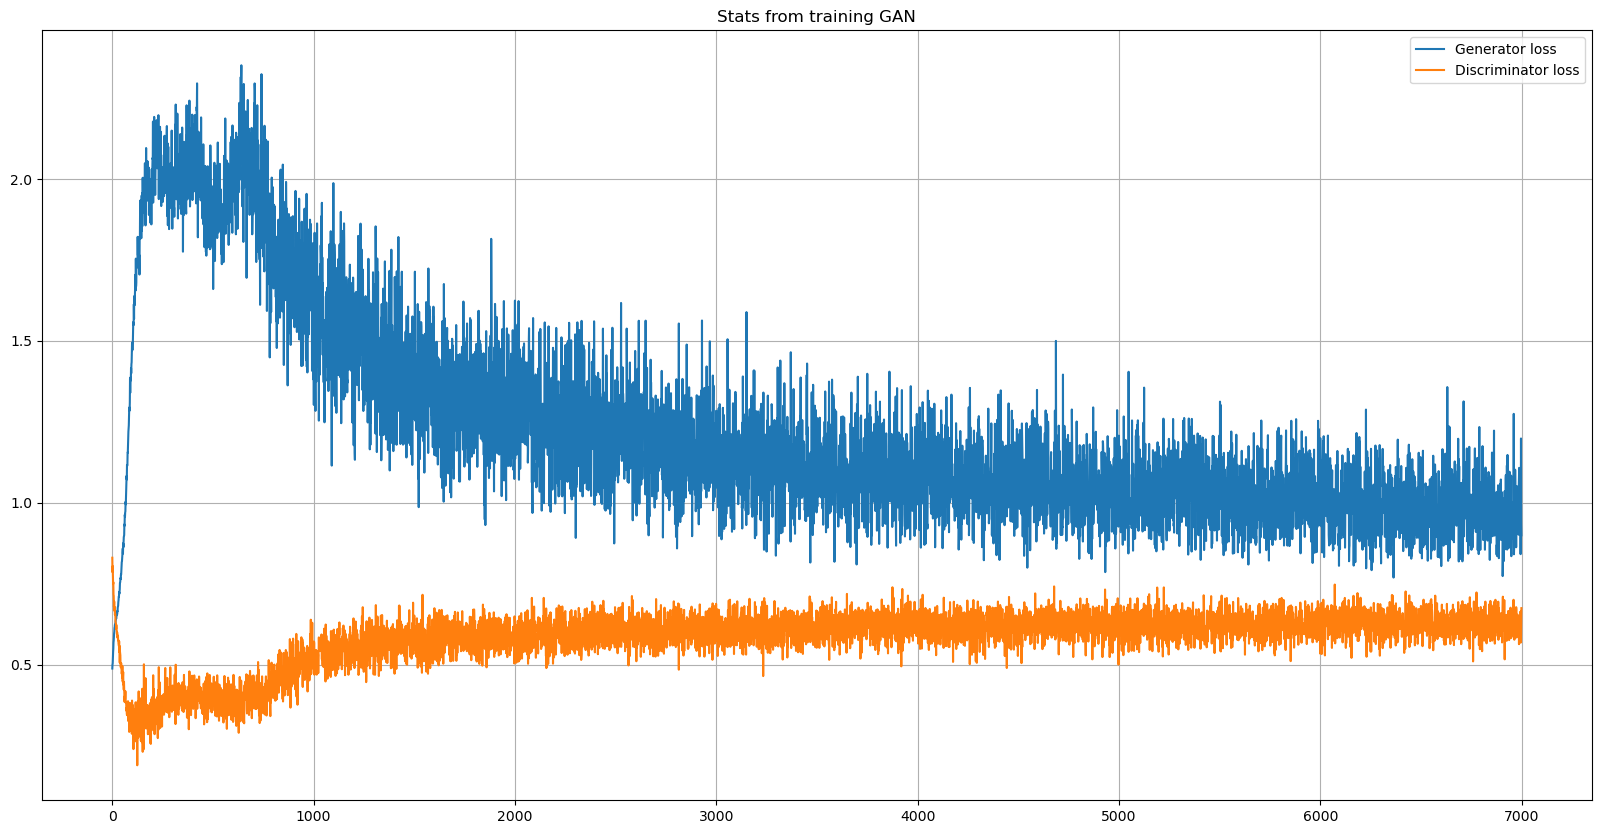

In [ ]:
latent_dim = 70 
gan_train(completegan, generator, discriminator, location_dummy.values,country_dummy.values,gender_dummy.values,vis_wuhan_dummy.values,from_wuhan_dummy.values,symptom1_dummy.values,symptom2_dummy.values,symptom3_dummy.values,symptom4_dummy.values,symptom5_dummy.values,symptom6_dummy.values,numerical_df_rescaled, latent_dim, n_epochs = 7000, n_batch = 63, n_eval = 200)

In [ ]:
noise = np.random.normal(0, 1, (96, 70))  
generated_mixed_data = generator.predict(noise)  
generated_mixed_data.shape
  



3/3 [==============================] - 0s 4ms/step


(96, 49)

In [ ]:
columns=list(location_dummy.columns)+list(country_dummy.columns)+list(gender_dummy.columns)+list(vis_wuhan_dummy.columns)+list(from_wuhan_dummy.columns)+list(symptom1_dummy.columns)+list(symptom2_dummy.columns)+list(symptom3_dummy.columns)+list(symptom4_dummy.columns)+list(symptom5_dummy.columns)+list(symptom6_dummy.columns)+list(numerical_df.columns)  
mixed_gen_df = pd.DataFrame(data = generated_mixed_data, columns = columns)  
mixed_gen_df.shape
mixed_gen_df.iloc[:,:-3] = np.round(mixed_gen_df.iloc[:,:-3]) 
mixed_gen_df
mixed_gen_df.iloc[:,-3:] = scaling.inverse_transform(mixed_gen_df.iloc[:,-3:])

age Comparison between Original Data and Generated Data


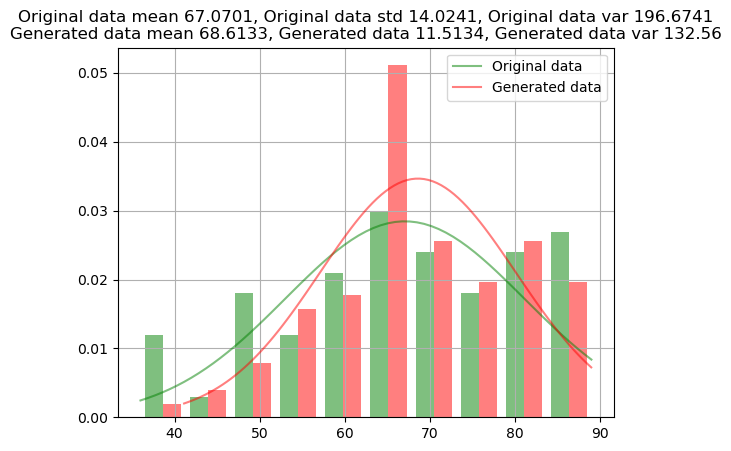

recov Comparison between Original Data and Generated Data


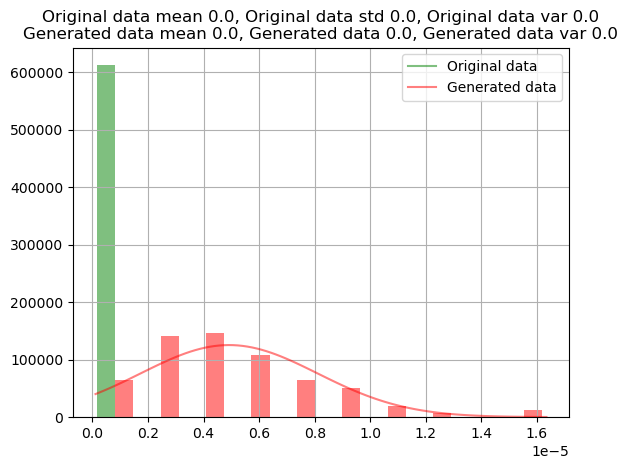

diff_sym_hos Comparison between Original Data and Generated Data


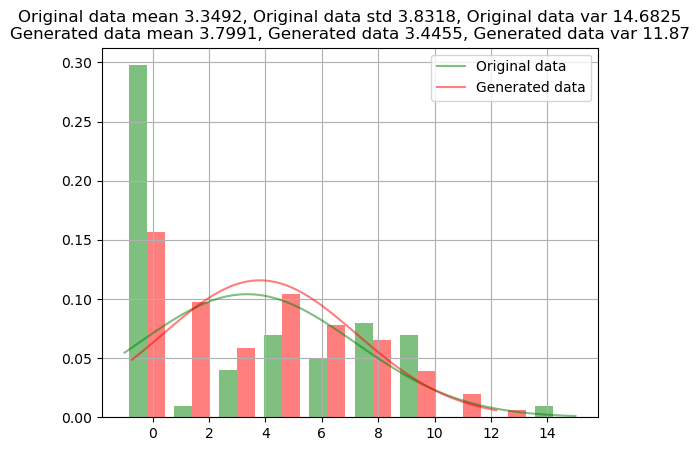

In [ ]:
#Original Data
original_df = pd.concat([location_dummy,country_dummy,gender_dummy,vis_wuhan_dummy,from_wuhan_dummy,symptom1_dummy,symptom2_dummy,symptom3_dummy,symptom4_dummy,symptom5_dummy,symptom6_dummy,numerical_df], axis = 1)  
def normal_distribution(org, noise):  
    org_x = np.linspace(org.min(), org.max(), len(org))  
    noise_x = np.linspace(noise.min(), noise.max(), len(noise))  
    org_y = scipy.stats.norm.pdf(org_x, org.mean(), org.std())  
    noise_y = scipy.stats.norm.pdf(noise_x, noise.mean(), noise.std())  
    n, bins, patches = plt.hist([org, noise], density = True, alpha = 0.5, color = ["green", "red"])  
    xmin, xmax = plt.xlim()  
    plt.plot(org_x, org_y, color = "green", label = "Original data", alpha = 0.5)  
    plt.plot(noise_x, noise_y, color = "red", label = "Generated data", alpha = 0.5)  
    title = f"Original data mean {np.round(org.mean(), 4)}, Original data std {np.round(org.std(), 4)}, Original data var {np.round(org.var(), 4)}\nGenerated data mean {np.round(noise.mean(), 4)}, Generated data {np.round(noise.std(), 4)}, Generated data var {np.round(noise.var(), 2)}"
    plt.title(title)  
    plt.legend()  
    plt.grid()  
    plt.show()  

Numeric_columns=numerical_df.columns  

for column in numerical_df.columns:  
    print(column, "Comparison between Original Data and Generated Data")  
    normal_distribution(original_df[column], mixed_gen_df[column]) 


In [ ]:
# Getting Back Categorical Data in Original_Format from Dummies
location_filter_col = [col for col in mixed_gen_df if col.startswith('location')]  
location=mixed_gen_df[location_filter_col]   
location= pd.get_dummies(location).idxmax(1)  
location= location.replace('location_', '', regex=True)  
df_generated_data = pd.DataFrame()   
df_generated_data['location']=location  

country_filter_col = [col for col in mixed_gen_df if col.startswith('country')]  
country=mixed_gen_df[country_filter_col]   
country= pd.get_dummies(country).idxmax(1)  
country= country.replace('country_', '', regex=True)  
df_generated_data['country']=country  

gender_filter_col = [col for col in mixed_gen_df if col.startswith('gender')]  
gender=mixed_gen_df[gender_filter_col]   
gender= pd.get_dummies(gender).idxmax(1)  
gender= gender.replace('gender_', '', regex=True)  
df_generated_data['gender']=gender  

vis_wuhan_filter_col = [col for col in mixed_gen_df if col.startswith('vis_wuhan')]  
vis_wuhan=mixed_gen_df[vis_wuhan_filter_col]   
vis_wuhan= pd.get_dummies(vis_wuhan).idxmax(1)  
vis_wuhan= vis_wuhan.replace('vis_wuhan_', '', regex=True)  
df_generated_data['vis_wuhan']=vis_wuhan  

from_wuhan_filter_col = [col for col in mixed_gen_df if col.startswith('from_wuhan')]  
from_wuhan=mixed_gen_df[from_wuhan_filter_col]   
from_wuhan= pd.get_dummies(from_wuhan).idxmax(1)  
from_wuhan= from_wuhan.replace('from_wuhan_', '', regex=True)  
df_generated_data['from_wuhan']=from_wuhan  

symptom1_filter_col = [col for col in mixed_gen_df if col.startswith('symptom1')]  
symptom1=mixed_gen_df[symptom1_filter_col]   
symptom1= pd.get_dummies(symptom1).idxmax(1)  
symptom1= symptom1.replace('symptom1_', '', regex=True)  
df_generated_data['symptom1']=symptom1  

symptom2_filter_col = [col for col in mixed_gen_df if col.startswith('symptom2')]  
symptom2=mixed_gen_df[symptom2_filter_col]   
symptom2= pd.get_dummies(symptom2).idxmax(1)  
symptom2= symptom2.replace('symptom2_', '', regex=True)  
df_generated_data['symptom2']=symptom2  

symptom3_filter_col = [col for col in mixed_gen_df if col.startswith('symptom3')]  
symptom3=mixed_gen_df[symptom3_filter_col]   
symptom3= pd.get_dummies(symptom3).idxmax(1)  
symptom3= symptom3.replace('symptom3_', '', regex=True)  
df_generated_data['symptom3']=symptom3  

symptom4_filter_col = [col for col in mixed_gen_df if col.startswith('symptom4')]  
symptom4=mixed_gen_df[symptom4_filter_col]   
symptom4= pd.get_dummies(symptom4).idxmax(1)  
symptom4= symptom4.replace('symptom4_', '', regex=True)  
df_generated_data['symptom4']=symptom4  

symptom5_filter_col = [col for col in mixed_gen_df if col.startswith('symptom5')]  
symptom5=mixed_gen_df[symptom5_filter_col]   
symptom5= pd.get_dummies(symptom5).idxmax(1)  
symptom5= symptom5.replace('symptom5_', '', regex=True)  
df_generated_data['symptom5']=symptom5  

symptom6_filter_col = [col for col in mixed_gen_df if col.startswith('symptom6')]  
symptom6=mixed_gen_df[symptom6_filter_col]   
symptom6= pd.get_dummies(symptom6).idxmax(1)  
symptom6= symptom6.replace('symptom6_', '', regex=True)  
df_generated_data['symptom6']=symptom6  

df_generated_data['death']=1  
df_generated_data['death']=1  

df_generated_data[['age','diff_sym_hos']]=mixed_gen_df[['age','diff_sym_hos']]  
df_generated_data = df_generated_data.fillna(np.nan,axis=0)  


#Encoding Data
from sklearn import preprocessing
encoder_location = preprocessing.LabelEncoder()  
encoder_country = preprocessing.LabelEncoder()  
encoder_gender = preprocessing.LabelEncoder()  
encoder_symptom1 = preprocessing.LabelEncoder()  
encoder_symptom2 = preprocessing.LabelEncoder()  
encoder_symptom3 = preprocessing.LabelEncoder()  
encoder_symptom4 = preprocessing.LabelEncoder()  
encoder_symptom5 = preprocessing.LabelEncoder()  
encoder_symptom6 = preprocessing.LabelEncoder()  

# Loading and Preparing Data
df = pd.read_csv('data.csv')  
df = df.drop('id',axis=1)  
df = df.fillna(np.nan,axis=0)  
df['age'] = df['age'].fillna(value=df['age'].mean())  
df['sym_on'] = pd.to_datetime(df['sym_on'])  
df['hosp_vis'] = pd.to_datetime(df['hosp_vis'])  
df['sym_on']= df['sym_on'].map(dt.datetime.toordinal)  
df['hosp_vis']= df['hosp_vis'].map(dt.datetime.toordinal)  
df['diff_sym_hos']= df['hosp_vis'] - df['sym_on']  
df = df.drop(['sym_on','hosp_vis'],axis=1)  
df['from_wuhan'] = df['from_wuhan'].fillna(value=0.0)  
df['recov'] = df['recov'].fillna(value=0)
      
df['location'] = encoder_location.fit_transform(df['location'].astype(str))  
df['country'] = encoder_country.fit_transform(df['country'].astype(str))  
df['gender'] = encoder_gender.fit_transform(df['gender'].astype(str))  
df['symptom1'] = encoder_symptom1.fit_transform(df['symptom1'].astype(str))  
df['symptom2'] = encoder_symptom2.fit_transform(df['symptom2'].astype(str))  
df['symptom3'] = encoder_symptom3.fit_transform(df['symptom3'].astype(str))  
df['symptom4'] = encoder_symptom4.fit_transform(df['symptom4'].astype(str))  
df['symptom5'] = encoder_symptom5.fit_transform(df['symptom5'].astype(str))  
df['symptom6'] = encoder_symptom6.fit_transform(df['symptom6'].astype(str))  

# Encoding Generated Data  
df_generated_data['location'] = encoder_location.transform(df_generated_data['location'].astype(str))  
df_generated_data['country'] = encoder_country.transform(df_generated_data['country'].astype(str))  
df_generated_data['gender'] = encoder_gender.transform(df_generated_data['gender'].astype(str))  
df_generated_data['symptom1'] = encoder_symptom1.transform(df_generated_data['symptom1'].astype(str))  
df_generated_data['symptom2'] = encoder_symptom2.transform(df_generated_data['symptom2'].astype(str))  
df_generated_data['symptom3'] = encoder_symptom3.transform(df_generated_data['symptom3'].astype(str))  
df_generated_data['symptom4']= encoder_symptom4.transform(df_generated_data['symptom4'].astype(str))  
df_generated_data['symptom5'] = encoder_symptom5.transform(df_generated_data['symptom5'].astype(str))  
df_generated_data['symptom6'] = encoder_symptom6.transform(df_generated_data['symptom6'].astype(str))  
df_generated_data['diff_sym_hos'] = df_generated_data['diff_sym_hos'].astype(int)

In [ ]:
df_generated_data

,location,country,gender,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,death,age,diff_sym_hos
0,147,8,0,0,1.0,17,31,23,12,3,1,1,72.907013,1
1,47,19,1,0,0.0,5,31,23,12,3,1,1,82.462036,1
2,120,27,1,0,0.0,17,31,23,12,3,1,1,62.976509,0
3,49,8,0,0,0.0,17,31,23,12,3,1,1,74.528145,2
4,147,8,1,0,1.0,17,31,23,12,3,1,1,78.713875,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,120,27,1,0,0.0,17,31,23,12,3,1,1,70.091209,0
92,147,8,1,0,1.0,17,31,23,12,3,1,1,75.848923,4
93,147,8,1,0,1.0,17,31,23,12,3,1,1,62.149464,6
94,147,8,1,0,1.0,17,31,23,12,3,1,1,80.731247,0


In [ ]:
df.isna().any()

location        False
country         False
gender          False
age             False
vis_wuhan       False
from_wuhan      False
death           False
recov           False
symptom1        False
symptom2        False
symptom3        False
symptom4        False
symptom5        False
symptom6        False
diff_sym_hos    False
dtype: bool

In [ ]:
df_generated_data.isna().any()

location        False
country         False
gender          False
vis_wuhan       False
from_wuhan      False
symptom1        False
symptom2        False
symptom3        False
symptom4        False
symptom5        False
symptom6        False
death           False
age             False
diff_sym_hos    False
dtype: bool

In [ ]:
from sklearn.metrics import recall_score as rs  
from sklearn.metrics import precision_score as ps  
from sklearn.metrics import f1_score as f1 
from sklearn.metrics import balanced_accuracy_score as bas  
from sklearn.metrics import confusion_matrix as cm  
import numpy as np  
import pandas as pd  
import datetime as dt  
import sklearn  
from scipy import stats  
from sklearn import preprocessing  
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import AdaBoostClassifier  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import log_loss  

rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,  
criterion='gini', max_depth=2, max_features='auto',  
max_leaf_nodes=None, max_samples=None,  
min_impurity_decrease=0.0,
min_samples_leaf=2, min_samples_split=2,  
min_weight_fraction_leaf=0.0, n_estimators=100,  
n_jobs=None, oob_score=False, random_state=None,  
verbose=0, warm_start=False)  
classifier = AdaBoostClassifier(base_estimator=rf, n_estimators=50, learning_rate=0.01, algorithm='SAMME.R', random_state=10)

#Seperate TV in Generated Data
X1 = df_generated_data.loc[:, df_generated_data.columns != 'death']  
Y1 = df_generated_data['death']  

#Seperate TV in Original Data
X = df.loc[:, df.columns != 'death']  
Y = df['death']  



In [ ]:
#Splitting Original Data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)  

#Appending Generated Data to X_train
X_train1=X_train.append(X1, sort=False)  
Y_train1=Y_train.append(Y1)  


In [ ]:
#BASE MODEL- boost
classifier.fit(X_train,np.array(Y_train).reshape(Y_train.shape[0],1))
pred = np.array(classifier.predict(X_test))
recall_base = rs(Y_test,pred)
precision_base = ps(Y_test,pred)
f1_base = f1(Y_test,pred)
accuracy_base = classifier.score(X_test,Y_test)
print('*** Evaluation metrics for test dataset ***\n')
print('Recall Score: ',recall_base)
print('Precision Score: ',precision_base)
print('F1 Score: ',f1_base)
print('Accuracy: ',accuracy_base)

*** Evaluation metrics for test dataset ***

Recall Score:  0.25
Precision Score:  1.0
F1 Score:  0.4
Accuracy:  0.9585253456221198


In [ ]:
#checking for missing value
X_train1.isna().any()

location        False
country         False
gender          False
age             False
vis_wuhan       False
from_wuhan      False
recov            True
symptom1        False
symptom2        False
symptom3        False
symptom4        False
symptom5        False
symptom6        False
diff_sym_hos    False
dtype: bool

In [ ]:
X_train1['recov']= X_train1['recov'].fillna(value=0)

In [ ]:
#GAN
classifier.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
pred = np.array(classifier.predict(X_test))
recall_gan = rs(Y_test,pred)
precision_gan = ps(Y_test,pred)
f1_gan = f1(Y_test,pred)
accuracy_gan = classifier.score(X_test,Y_test)
print('*** Evaluation metrics for test dataset ***\n')
print('Recall Score: ',recall_gan)
print('Precision Score: ',precision_gan)
print('F1 Score: ',f1_gan)
print('Accuracy: ',accuracy_gan)

*** Evaluation metrics for test dataset ***

Recall Score:  0.3333333333333333
Precision Score:  1.0
F1 Score:  0.5
Accuracy:  0.9631336405529954


In [ ]:
#SMOTE Oversampling

In [ ]:
!pip install --upgrade scikit-learn
!pip install imbalanced-learn


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [ ]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, Y_train)

# Verify that the classes are balanced
print('Original dataset shape:', Y_train.value_counts())
print('Resampled dataset shape:', y_train_smote.value_counts())

Original dataset shape: 0    817
1     51
Name: death, dtype: int64
Resampled dataset shape: 0    817
1    817
Name: death, dtype: int64


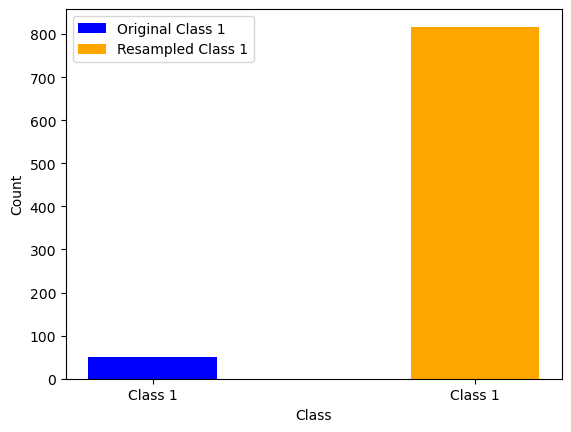

In [ ]:
# Get class counts for original and resampled data
original_counts = Y_train.value_counts()
resampled_counts = y_train_smote.value_counts()
# Create a bar plot
fig, ax = plt.subplots()
ax.bar(1, original_counts[1], label='Original Class 1', color='b')
ax.bar(3, resampled_counts[1], label='Resampled Class 1', color='orange')
ax.set_xticks([1,3])
ax.set_xticklabels([ 'Class 1', 'Class 1'])
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.legend()
plt.show()

In [ ]:
#Applying classifier on SMOTE resampled data
# Train a random forest classifier on the training data
clf=RandomForestClassifier(n_estimators=100,random_state=42)
clf.fit(X_train3,y_train3)
y_pred3=clf.predict(X_test3)
accuracy_smote_rf = clf.score(X_test3,y_test3)
precision_smote_rf = classification_report(y_test3,y_pred3,output_dict=True)['1']['precision']
f1_smote_rf = classification_report(y_test3,y_pred3,output_dict=True)['1']['f1-score']
recall_smote_rf = rs(y_test3,y_pred3) 
print("Model Trained on Resampled Data:")
print("Accuracy:",accuracy_smote_rf)
print("Precision:",precision_smote_rf)
print("F1-Score:",f1_smote_rf)
print("Recall:",recall_smote_rf)

Model Trained on Resampled Data:
Accuracy: 0.9755351681957186
Precision: 0.9738562091503268
F1-Score: 0.9738562091503268
Recall: 0.9738562091503268


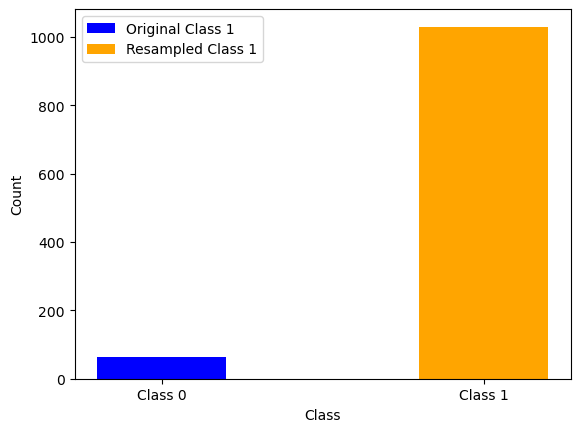

In [ ]:
#ADASYN Oversampling method
from imblearn.over_sampling import ADASYN

# Create ADASYN object with desired sampling strategy
adasyn=ADASYN(sampling_strategy='minority',n_jobs=-1)
# Perform ADASYN oversampling on the data
X_resampled,y_resampled=adasyn.fit_resample(X_train,Y_train)
original_counts=y.value_counts()
resampled_counts=y_resampled.value_counts()
fig,ax=plt.subplots()
ax.bar(1,original_counts[1],label='Original Class 1',color='b')
ax.bar(3,resampled_counts[1],label='Resampled Class 1',color='orange')
ax.set_xticks([1,3])
ax.set_xticklabels(['Class 0','Class 1'])
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.legend()
plt.show()

In [ ]:
#Applying classifier on ADASYN 
from sklearn.metrics import classification_report
X_train2,X_test2,y_train2,y_test2=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
# Train a random forest classifier on the training data
# ADASYN RF
clf=RandomForestClassifier(n_estimators=100,random_state=42)
clf.fit(X_train2,y_train2)
y_pred2=clf.predict(X_test2)
accuracy_adasyn_rf = clf.score(X_test2,y_test2)
precision_adasyn_rf = classification_report(y_test2,y_pred2,output_dict=True)['1']['precision']
f1_adasyn_rf = classification_report(y_test2,y_pred2,output_dict=True)['1']['f1-score']
recall_adasyn_rf = rs(y_test2,y_pred2)
print("Model Trained on Resampled Data:")
print("Accuracy:",accuracy_adasyn_rf)
print("Precision:",precision_adasyn_rf)
print("F1-Score:",f1_adasyn_rf)
print("Recall:",recall_adasyn_rf )

Model Trained on Resampled Data:
Accuracy: 0.9708029197080292
Precision: 0.9627906976744186
F1-Score: 0.971830985915493
Recall: 0.981042654028436


In [ ]:
results = {'MODEL': ['Base Model - Boost', 'GAN', 'SMOTE RF', 'ADASYN RF'],
           'RECALL': [recall_base, recall_gan, recall_smote_rf, recall_adasyn_rf],
           'PRECISION': [precision_base, precision_gan, precision_smote_rf, precision_adasyn_rf],
           'ACCURACY': [accuracy_base, accuracy_gan, accuracy_smote_rf, accuracy_adasyn_rf],
           'F1 SCORE': [f1_base, f1_gan, f1_smote_rf, f1_adasyn_rf]}
df_results = pd.DataFrame(results, columns=['MODEL','RECALL','PRECISION','ACCURACY','F1 SCORE'])

In [ ]:
# Define the CSS styles for the table
styles = [
    {
        'selector': 'th', 
        'props': [
            ('font-weight', 'bold')
        ]
    }
]

# Create a Styler object and set the styles
styled_df = df_results.style.set_table_styles(styles)

# Display the styled dataframe
display(styled_df)

,MODEL,RECALL,PRECISION,ACCURACY,F1 SCORE
0,Base Model - Boost,0.250000,1.000000,0.958525,0.400000
1,GAN,0.333333,1.000000,0.963134,0.500000
2,SMOTE RF,0.973856,0.973856,0.975535,0.973856
3,ADASYN RF,0.981043,0.962791,0.970803,0.971831


Hence through the above comparitive analysis table, we can conclude that all four models perform relatively well
in terms of accuracy, with all models achieving an accuracy score of above 95%.
However, when it comes to recall and F1-score, we can see that the SMOTE and ADASYN models outperform the Base Model
and GAN models.The ADASYN RF model achieved the highest recall score of 0.981 and an F1-score of 0.971, indicating that it has a better ability to correctly identify positive cases. On the other hand, the GAN model achieved the lowest recall score of 0.333, indicating that it struggles to identify positive cases.The ADASYN RF model appears to be the most effective in identifying fraudulent transactions, achieving the highest recall and F1-score while maintaining a high level of accuracy. However, the choice of the best model also depends on the specific requirements and constraints of the task.